## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
%matplotlib inline


"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [2]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./data/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", standardized=False):

    
    outputs = None
    global_mean = 0
    global_std = 0
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        if standardized:
            inputs = np.asarray(inputs)
            global_mean = np.mean(inputs, axis = (0,1), keepdims = True)
            global_std = np.std(np.sqrt(inputs[:, :, 0]**2 + inputs[:, :, 0]**2))
        inputs = np.asarray(inputs)[:int(n * 0.7)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.7)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        if standardized:
            inputs = np.asarray(inputs)
            global_mean = np.mean(inputs, axis = (0,1), keepdims = True)
            global_std = np.std(np.sqrt(inputs[:, :, 0]**2 + inputs[:, :, 0]**2))
        inputs = np.asarray(inputs)[int(n * 0.7):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.7):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        if standardized:
            inputs = np.asarray(inputs)
            global_mean = np.mean(inputs, axis = (0,1), keepdims = True)
            global_std = np.std(np.sqrt(inputs[:, :, 0]**2 + inputs[:, :, 0]**2))
        else:
            inputs = np.asarray(inputs)

    if standardized:
        standard_inputs = (inputs - global_mean)/global_std
        standard_targets = (outputs - global_mean)/global_std
        return standard_inputs, standard_targets
    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, standardized:bool, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform
        self.standardized = standardized

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, standardized=self.standardized)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

In [3]:
# intialize a dataset
def get_data_loader(city = 'austin', batch_size = 20, standardized=False):
    train_dataset  = ArgoverseDataset(city = city, split = 'train', standardized=standardized)
    val_dataset = ArgoverseDataset(city = city, split = 'val', standardized=standardized)

    train_loader = DataLoader(train_dataset,batch_size=batch_size)
    val_loader = DataLoader(val_dataset,batch_size=batch_size)
    return train_dataset, val_dataset, train_loader, val_loader

In [4]:
train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = 'austin', batch_size = 50, standardized=True)

In [5]:
len(val_dataset)

12913

In [6]:
len(train_dataset)

30128

## Create a DataLoader class for training

In [7]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate):
        
        super(Encoder, self).__init__()

        self.lstm = nn.LSTM(input_size = input_dim, 
                            hidden_size = hidden_dim, 
                            num_layers= num_layers, 
                            dropout = dropout_rate,
                            batch_first = True)
#         self.lstm = nn.Sequential(OrderedDict([
#             ('LSTM1', nn.LSTM(input_size = input_dim, hidden_size = hidden_dim, num_layers = 1, batch_first=True)),
#             ('LSTM2', nn.LSTM(input_size = input_dim, hidden_size = hidden_dim, num_layers = 1, batch_first=True))]))
        
        
    def forward(self, source):
        
        # hidden = (h, c)
        # h, c: num_layers x bz x  hid_dim
        # outputs: bz x input_length x hid_dim
        outputs, hidden = self.lstm(source)
        
        return outputs, hidden
    
class AttnDecoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers, dropout_rate):

        super(AttnDecoder, self).__init__()

        # Learn the attention scores
        self.attn = nn.Linear(hidden_dim + output_dim, 50)
        
        # Learn the final input to the decoder 
        self.attn_combine = nn.Linear(hidden_dim + output_dim, hidden_dim)
        
        # Decoder LSTM
        self.lstm = nn.LSTM(input_size = hidden_dim, 
                            hidden_size = hidden_dim, 
                            num_layers= num_layers, 
                            dropout = dropout_rate, 
                            batch_first = True)
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
      
    def forward(self, x, hidden, encoder_outputs):
        
        h = hidden[0]
        h = h.transpose(0,1).reshape(h.shape[1], -1)
        
        # Compute Attention Scores
        attn_weights = F.softmax(self.attn(torch.cat([x, h], 1)), dim =1)
        
        # Calculate weighted sum of encoder hidden states     
        attn_applied = torch.einsum("bl,blh->bh", attn_weights, encoder_outputs)
        
        x = torch.cat((x, attn_applied), dim = 1)
        x = self.attn_combine(x).unsqueeze(1)
        x = F.relu(x)
        
        output, decoder_hidden= self.lstm(x, hidden)  
        prediction = self.output_layer(output.float())
        
        return prediction.squeeze(1), decoder_hidden
    
class Seq2Seq(nn.Module):
    def __init__(self, input_dim = 2, output_dim = 2, hidden_dim = 128, num_layers = 1, dropout_rate = 0, cuda = True):
        
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, num_layers, dropout_rate)
        self.decoder = AttnDecoder(output_dim, hidden_dim, num_layers, dropout_rate)
        self.gpu = cuda

    def forward(self, source, target_length):
        if self.gpu:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            self.to(device)
        
        batch_size = source.size(0) 
        input_length = source.size(1) 
        
        encoder_outputs, concat_hidden = self.encoder(source.cuda())
        
        # the last encoder hidden state is used as initial hidden state of the decoder
        decoder_hidden = concat_hidden
        # the first input to the decoder is last input position
        decoder_output = source[:,-1]
    
        
        outputs = torch.zeros(batch_size, target_length, 2)
        for t in range(target_length):    
            decoder_output, decoder_hidden = self.decoder(decoder_output, decoder_hidden, encoder_outputs)
            outputs[:,t] = decoder_output   
        return outputs

In [8]:
# model, optimizer, loss
model_encdoc = Seq2Seq()
opt = optim.Adam(model_encdoc.parameters(), lr=1e-3)
loss_func = nn.MSELoss()

In [9]:
def train_epochs(model, train_loader, loss_func, opt, cuda, epochs = 10):

    if cuda:
        model.cuda()

    train_losses = []
    for epoch in range(epochs):

        total_loss = 0
        for i_batch, sample_batch in enumerate(train_loader):
            inp, out = sample_batch
            if cuda:
                inp, out = inp.cuda(), out.cuda()
            out = out.float()
            preds = model(inp.float(), target_length=60)
            if cuda:
                preds.cuda()
            #loss = loss_func(preds, out) # MSE
            loss = torch.sqrt(loss_func(preds.cuda(), out.cuda())) # RMSE

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()

        print('epoch {} trian loss: {}'.format(epoch, total_loss / len(train_dataset)))
        train_losses.append(total_loss / len(train_dataset))
    return train_losses

In [10]:
def val_loss(model, val_loader, loss_func, opt, cuda=False):
    val_loss = 0
    if cuda:
        model.cuda()
    for i_batch, sample_batch in enumerate(val_loader):
        inp, out = sample_batch
        if cuda:
            inp, out = inp.cuda(), out.cuda()
        out = out.float()
        preds = model(inp.float(), target_length=60)
        #loss = loss_func(preds, out) # MSE
        loss = torch.sqrt(loss_func(preds.cuda(), out.cuda())) # RMSE

        val_loss += loss.item()
    print('val loss: {}'.format(val_loss / len(val_dataset)))

In [11]:
def train_city(city, batch_size, standardized, epochs, cuda=False):
    # data loader
    train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = city, batch_size = batch_size, standardized=standardized)
    
    # model, optimizer, loss
    model_encdoc = Seq2Seq(hidden_dim=500)
    opt = optim.Adam(model_encdoc.parameters(), lr=1e-3)
    loss_func = nn.MSELoss()
    
    # train
    train_losses = train_epochs(model_encdoc, train_loader, loss_func, opt, epochs = epochs, cuda = cuda)
    
    # evaluate
    # val_loss(model_encdoc, val_loader, loss_func, opt)
    return model_encdoc, train_losses

In [12]:
model_austin, train_losses = train_city('austin', batch_size = 50, standardized = True, epochs = 40, cuda=True)

epoch 0 trian loss: 0.0011371042740403166
epoch 1 trian loss: 0.0005258906136088339
epoch 2 trian loss: 0.0004227658676167043
epoch 3 trian loss: 0.00037743640558836675
epoch 4 trian loss: 0.0003776994759001261
epoch 5 trian loss: 0.0003522649211465296
epoch 6 trian loss: 0.00034795131547815715
epoch 7 trian loss: 0.00034256908395666425
epoch 8 trian loss: 0.00032994186806636433
epoch 9 trian loss: 0.0003213340728331023
epoch 10 trian loss: 0.00031632523813947196
epoch 11 trian loss: 0.00031009440040621417
epoch 12 trian loss: 0.00030547305095824105
epoch 13 trian loss: 0.0003016412353234101
epoch 14 trian loss: 0.0002991665289843622
epoch 15 trian loss: 0.0002974701389797483
epoch 16 trian loss: 0.0003862808819808782
epoch 17 trian loss: 0.0003054683415164288
epoch 18 trian loss: 0.0002975924785307792
epoch 19 trian loss: 0.0002943068022868906
epoch 20 trian loss: 0.0002922858557932423
epoch 21 trian loss: 0.0002905012154630205
epoch 22 trian loss: 0.0002881120448025459
epoch 23 trian

Text(0, 0.5, 'RMSE')

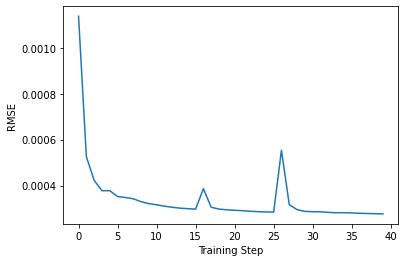

In [13]:
plt.plot(train_losses)
plt.xlabel('Training Step')
plt.ylabel('RMSE')

In [14]:
val_loss(model_austin, val_loader, loss_func, opt, cuda=True)

val loss: 0.0002650262327505738


In [15]:
model_miami, train_losses = train_city('miami', batch_size = 50, epochs = 40, standardized=True, cuda=True)

epoch 0 trian loss: 0.0009566348197101355
epoch 1 trian loss: 0.000417605040139166
epoch 2 trian loss: 0.0003397930534969495
epoch 3 trian loss: 0.0003090965460733161
epoch 4 trian loss: 0.0002820392321205173
epoch 5 trian loss: 0.0002601571511448793
epoch 6 trian loss: 0.00023666282731382374
epoch 7 trian loss: 0.0002336256780136877
epoch 8 trian loss: 0.00021257734674128465
epoch 9 trian loss: 0.00020246497226868615
epoch 10 trian loss: 0.0002043761328695885
epoch 11 trian loss: 0.00018615310685115603
epoch 12 trian loss: 0.00017917149230235404
epoch 13 trian loss: 0.0001708934648284927
epoch 14 trian loss: 0.00016592170733293747
epoch 15 trian loss: 0.00016066754087264168
epoch 16 trian loss: 0.0001590360570081351
epoch 17 trian loss: 0.00014968007636717478
epoch 18 trian loss: 0.0001435809113258749
epoch 19 trian loss: 0.00014934868074846475
epoch 20 trian loss: 0.0001433797699467423
epoch 21 trian loss: 0.00013808587822620224
epoch 22 trian loss: 0.00012374585009695873
epoch 23 tr

In [16]:
train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = 'miami', batch_size = 50, standardized=True)

In [17]:
val_loss(model_miami, val_loader, loss_func, opt, cuda=True)

val loss: 4.4566999905493304e-05


In [18]:
model_pittsburgh, train_losses = train_city('pittsburgh', batch_size = 50, epochs = 40, standardized=True, cuda=True)

epoch 0 trian loss: 0.0006072052085708328
epoch 1 trian loss: 0.0002860939664029258
epoch 2 trian loss: 0.00023058048681078453
epoch 3 trian loss: 0.00020284697008227323
epoch 4 trian loss: 0.00019026605621742343
epoch 5 trian loss: 0.00018135533801803166
epoch 6 trian loss: 0.00017929468875719953
epoch 7 trian loss: 0.00017049597881624122
epoch 8 trian loss: 0.0001633501121327513
epoch 9 trian loss: 0.00016074961511687078
epoch 10 trian loss: 0.00015977836323530643
epoch 11 trian loss: 0.0001545041195225253
epoch 12 trian loss: 0.0001516230286873668
epoch 13 trian loss: 0.00015198683701281513
epoch 14 trian loss: 0.00014757660538178646
epoch 15 trian loss: 0.00014675265964582903
epoch 16 trian loss: 0.00014556000970965513
epoch 17 trian loss: 0.0001439745466129106
epoch 18 trian loss: 0.00014254314928177284
epoch 19 trian loss: 0.00014148805125327327
epoch 20 trian loss: 0.0001403372907534296
epoch 21 trian loss: 0.00013952998299130383
epoch 22 trian loss: 0.00013870599290147144
epoch

In [19]:
train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = 'pittsburgh', batch_size = 50, standardized=True)
val_loss(model_pittsburgh, val_loader, loss_func, opt, cuda=True)

val loss: 0.00017357968541480422


In [20]:
model_dearborn, train_losses = train_city('dearborn', batch_size = 50, epochs = 40, standardized=True, cuda=True)

epoch 0 trian loss: 0.0006806269621114757
epoch 1 trian loss: 0.00018470314697404037
epoch 2 trian loss: 0.00014137982983897463
epoch 3 trian loss: 0.0001424878605750201
epoch 4 trian loss: 0.0001270695739967157
epoch 5 trian loss: 0.00011375711780417896
epoch 6 trian loss: 0.00012205217344982163
epoch 7 trian loss: 0.00010049619334273216
epoch 8 trian loss: 0.00010311482289348903
epoch 9 trian loss: 9.923219889172614e-05
epoch 10 trian loss: 9.026309390359233e-05
epoch 11 trian loss: 9.309850762087334e-05
epoch 12 trian loss: 8.775378345802739e-05
epoch 13 trian loss: 8.298970673054828e-05
epoch 14 trian loss: 8.606463155875428e-05
epoch 15 trian loss: 7.915935659991318e-05
epoch 16 trian loss: 8.379063271707183e-05
epoch 17 trian loss: 7.814596091785769e-05
epoch 18 trian loss: 8.043473425414168e-05
epoch 19 trian loss: 7.45579167978051e-05
epoch 20 trian loss: 7.628359209460125e-05
epoch 21 trian loss: 7.65871629668913e-05
epoch 22 trian loss: 7.395459396466417e-05
epoch 23 trian lo

In [21]:
train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = 'dearborn', batch_size = 50, standardized=True)
val_loss(model_dearborn, val_loader, loss_func, opt, cuda=True)

val loss: 0.00010181897749987302


In [22]:
model_washington_dc, train_losses = train_city('washington-dc', batch_size = 50, epochs = 40, standardized=True, cuda=True)

epoch 0 trian loss: 0.0012942364559556446
epoch 1 trian loss: 0.0004325529447328435
epoch 2 trian loss: 0.00035802489366844624
epoch 3 trian loss: 0.00032617079210977483
epoch 4 trian loss: 0.00029146402524988146
epoch 5 trian loss: 0.0002751441581623398
epoch 6 trian loss: 0.0002667858763767855
epoch 7 trian loss: 0.0002574098400064628
epoch 8 trian loss: 0.00025218938840349225
epoch 9 trian loss: 0.00024311961935166894
epoch 10 trian loss: 0.00024364330075735593
epoch 11 trian loss: 0.00024203794319046674
epoch 12 trian loss: 0.00023825732072013138
epoch 13 trian loss: 0.00024056319908721604
epoch 14 trian loss: 0.000236691374250137
epoch 15 trian loss: 0.00023136790379555555
epoch 16 trian loss: 0.00022839038530840492
epoch 17 trian loss: 0.0002282000734695118
epoch 18 trian loss: 0.0002258814467239554
epoch 19 trian loss: 0.00022257525106742434
epoch 20 trian loss: 0.0002199232217984913
epoch 21 trian loss: 0.00021815254131372827
epoch 22 trian loss: 0.0002168218157369725
epoch 23 

In [23]:
train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = 'washington-dc', batch_size = 50, standardized=True)
val_loss(model_washington_dc, val_loader, loss_func, opt, cuda=True)

val loss: 0.00024978608661777366


In [24]:
model_palo_alto, train_losses = train_city('palo-alto', batch_size = 50, epochs = 40, standardized=True, cuda=True)

epoch 0 trian loss: 0.001348578028141063
epoch 1 trian loss: 0.0005232707951858755
epoch 2 trian loss: 0.0004649779369659747
epoch 3 trian loss: 0.00039472600515439826
epoch 4 trian loss: 0.00036243116813861704
epoch 5 trian loss: 0.00032403662885548536
epoch 6 trian loss: 0.00032460109395833974
epoch 7 trian loss: 0.0002996893874581461
epoch 8 trian loss: 0.0003067456742957416
epoch 9 trian loss: 0.00030573669957466315
epoch 10 trian loss: 0.0002951329867546752
epoch 11 trian loss: 0.0002946966511717316
epoch 12 trian loss: 0.000289457500472946
epoch 13 trian loss: 0.0002808932081633945
epoch 14 trian loss: 0.0002806339097663049
epoch 15 trian loss: 0.00027095975052486776
epoch 16 trian loss: 0.0002726101532545391
epoch 17 trian loss: 0.0002687228280228132
epoch 18 trian loss: 0.0002658880103821892
epoch 19 trian loss: 0.00026347752036185693
epoch 20 trian loss: 0.00026121636476371846
epoch 21 trian loss: 0.0002594375002976263
epoch 22 trian loss: 0.00025797990583850856
epoch 23 trian

In [25]:
train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = 'palo-alto', batch_size = 50, standardized=True)
val_loss(model_palo_alto, val_loader, loss_func, opt, cuda=True)

val loss: 0.0004910958274420332


## Make Prediction

In [26]:
cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
models = [model_austin, model_miami, model_pittsburgh, model_dearborn, model_washington_dc, model_palo_alto]

In [27]:
def predict_test(city, model):
    test_dataset = get_city_trajectories(city = city, split = 'test', standardized=False)[0]
    global_mean = np.mean(test_dataset, axis = (0,1), keepdims = True)
    global_std = np.std(np.sqrt(test_dataset[:, :, 0]**2 + test_dataset[:, :, 0]**2))
    test_dataset = (test_dataset - global_mean)/global_std
    test_dataset = torch.from_numpy(test_dataset).float()
    pred = model(test_dataset.cuda(), target_length=60)
    pred = pred.detach().numpy()
    pred = global_std * pred + global_mean
    pred = pred.reshape(-1, 120)
    return pd.DataFrame(pred)

In [28]:
columns =['ID'] + ['v'+str(i) for i in range(120)]

In [29]:
def predict_all(cities, models):
    out = predict_test(cities[0], models[0]).reset_index()
    out.columns = columns

    out['ID'] = out['ID'].astype(str) + '_' + cities[0]
    
    for city, model in zip(cities[1:], models[1:]):
        temp = predict_test(city, model).reset_index()
        temp.columns = columns
        temp['ID'] = temp['ID'].astype(str) + '_' + city
        out = pd.concat([out, temp])
    return out        

In [50]:
test_output = predict_all(cities, models)

RuntimeError: CUDA out of memory. Tried to allocate 130.00 MiB (GPU 0; 10.92 GiB total capacity; 9.61 GiB already allocated; 51.38 MiB free; 10.02 GiB reserved in total by PyTorch)

In [ ]:
test_output.to_csv('test_output.csv', index=False)

In [ ]:
test_output

## Sample a batch of data and visualize 

In [46]:
train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = 'washington-dc', batch_size = 5, standardized=False)

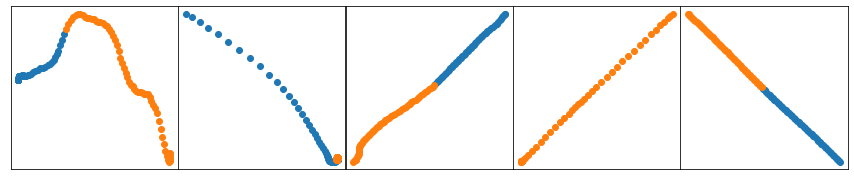

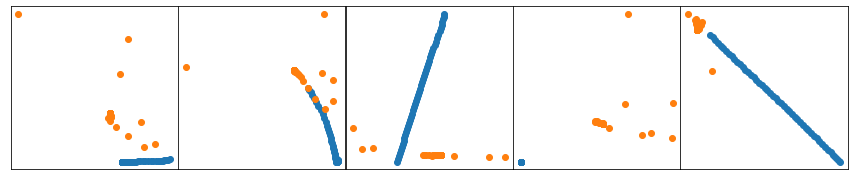

In [47]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])

        
for i_batch, sample_batch in enumerate(train_loader):
    if i_batch < 5: continue
    inp, out = sample_batch
    inp = np.asarray(inp)
    global_mean = np.mean(inp, axis = (0,1), keepdims = True)
    global_std = np.std(np.sqrt(inp[:, :, 0]**2 + inp[:, :, 0]**2))
    inp = (inp - global_mean) / global_std
    inp = torch.from_numpy(inp)
    inp = inp.float()
    pred = model_austin(inp.cuda(), target_length=60).detach()
    show_sample_batch(sample_batch)
    show_sample_batch([inp, pred])
    #print(sample_batch)
    break

In [48]:
train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = 'palo-alto', batch_size = 5, standardized=False)

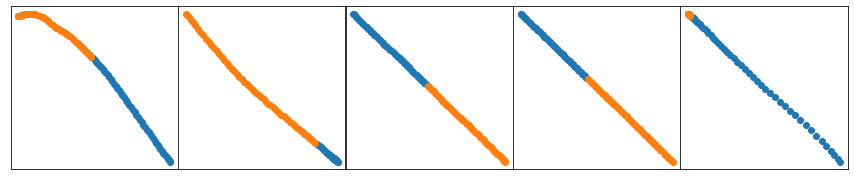

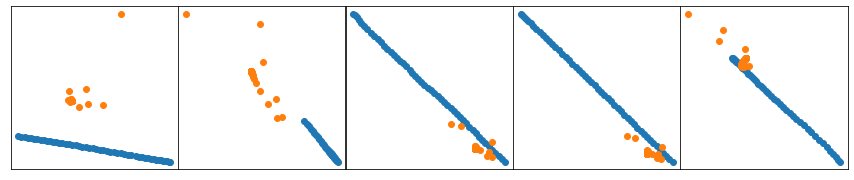

In [49]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])

        
for i_batch, sample_batch in enumerate(train_loader):
    if i_batch < 5: continue
    inp, out = sample_batch
    inp = np.asarray(inp)
    global_mean = np.mean(inp, axis = (0,1), keepdims = True)
    global_std = np.std(np.sqrt(inp[:, :, 0]**2 + inp[:, :, 0]**2))
    inp = (inp - global_mean) / global_std
    inp = torch.from_numpy(inp)
    inp = inp.float()
    pred = model_austin(inp.cuda(), target_length=60).detach()
    show_sample_batch(sample_batch)
    show_sample_batch([inp, pred])
    #print(sample_batch)
    break